In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer

from xgboost import XGBRegressor

from tqdm import tqdm
import time

In [3]:
# Read the data
csv_train_file = pd.read_csv('./siim-isic-melanoma-classification/train.csv')
csv_test_file = pd.read_csv('./siim-isic-melanoma-classification/test.csv')

# Separate target from predictors
y = csv_train_file.target
csv_train_file.drop(['target', 'benign_malignant', 'diagnosis'], axis=1, inplace=True)

X_train_load = csv_train_file
X_test_load = csv_test_file

In [4]:
print(f'Number of Training Examples = {X_train_load.shape[0]}')
print(f'Number of Test Examples = {X_test_load.shape[0]}\n')

print(f'Training X Shape = {X_train_load.shape}')
print(f'Training y Shape = {y.shape}\n')

print(f'Test X Shape = {X_test_load.shape}')

Number of Training Examples = 33126
Number of Test Examples = 10982

Training X Shape = (33126, 5)
Training y Shape = (33126,)

Test X Shape = (10982, 5)


In [5]:
def concat_df(X_train, X_test):
    # Returns a concatenated df of training and test set
    return pd.concat([X_train, X_test], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:33125], all_data.loc[33126:]

#### New Feature - Image Size

Inspired by https://www.kaggle.com/awsaf49/xgboost-tabular-data-ml-cv-85-lb-787

In [6]:
train_images = X_train_load['image_name'].values
train_sizes = np.zeros(train_images.shape[0])
for i, img_path in enumerate(tqdm(train_images)):
    train_sizes[i] = os.path.getsize(os.path.join('./siim-isic-melanoma-classification/jpeg/train/', f'{img_path}.jpg'))
    
X_train_load['image_size'] = train_sizes

test_images = X_test_load['image_name'].values
test_sizes = np.zeros(test_images.shape[0])
for i, img_path in enumerate(tqdm(test_images)):
    test_sizes[i] = os.path.getsize(os.path.join('./siim-isic-melanoma-classification/jpeg/test/', f'{img_path}.jpg'))
    
X_test_load['image_size'] = test_sizes

100%|██████████| 10982/10982 [00:00<00:00, 119025.32it/s]


In [7]:
#Aggregate the X data for further pre-processing
X_all = concat_df(X_train_load, X_test_load)

X_all.shape

(44108, 6)

#### New Feature - No of images per patient

Inspired by https://www.kaggle.com/awsaf49/xgboost-tabular-data-ml-cv-85-lb-787

In [8]:
X_all['n_images'] = X_all.patient_id.map(X_all.groupby(['patient_id']).image_name.count())

In [9]:
X_all['n_images'].describe()

count    44108.000000
mean        31.884647
std         28.074315
min          2.000000
25%         14.000000
50%         25.000000
75%         40.000000
max        240.000000
Name: n_images, dtype: float64

In [10]:
#Bin the image numbers into 10 bins
categorize_im_num = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'uniform')

X_all['n_images_enc'] = categorize_im_num.fit_transform(X_all['n_images'].values.reshape(-1, 1)).astype(int).squeeze()

In [11]:
# Scale and bin image size
scale = MinMaxScaler()
X_all['image_size_scaled'] = scale.fit_transform(X_all['image_size'].values.reshape(-1, 1))

categorize_im_size = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'uniform')
X_all['image_size_enc'] = categorize_im_size.fit_transform(X_all.image_size_scaled.values.reshape(-1, 1)).astype(int).squeeze()

#### New Feature - Age Min/Max

In [12]:
X_all['age_id_min']  = X_all['patient_id'].map(X_all.groupby(['patient_id']).age_approx.min())
X_all['age_id_max']  = X_all['patient_id'].map(X_all.groupby(['patient_id']).age_approx.max())

In [13]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44108 entries, 0 to 44107
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age_approx                     44040 non-null  float64
 1   anatom_site_general_challenge  43230 non-null  object 
 2   image_name                     44108 non-null  object 
 3   image_size                     44108 non-null  float64
 4   patient_id                     44108 non-null  object 
 5   sex                            44043 non-null  object 
 6   n_images                       44108 non-null  int64  
 7   n_images_enc                   44108 non-null  int64  
 8   image_size_scaled              44108 non-null  float64
 9   image_size_enc                 44108 non-null  int64  
 10  age_id_min                     44040 non-null  float64
 11  age_id_max                     44040 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usag

#### Feature Selection

In [14]:
# Select categorical columns
categorical_cols = ['sex', 'anatom_site_general_challenge']

# Select numerical columns
numerical_cols = ['age_approx','age_id_min','age_id_max', 'n_images', 'image_size_scaled']

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_all_card = X_all[my_cols].copy()

X_all_card.shape

(44108, 7)

In [15]:
X_train, X_test = divide_df(X_all_card)

print(f'Number of Training Examples = {X_train.shape[0]}')
print(f'Number of Test Examples = {X_test.shape[0]}')

Number of Training Examples = 33126
Number of Test Examples = 10982


In [21]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
                                ('imputern', SimpleImputer(strategy='constant')),
                                ('scaler', StandardScaler())
                                 ])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
                                ('imputerc', SimpleImputer(strategy='constant')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                ])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [17]:
xgb_gs = XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.002, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=700, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [18]:
def get_score(param_grid):

    score_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', xgb_gs)])
  
    
    search = GridSearchCV(score_pipeline, 
                          param_grid, 
                          #n_jobs=4,
                          cv=5,
                          verbose=3,
                          scoring='roc_auc'
                         )
    
    search.fit(X_train, y)
    
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    return search

In [66]:
param_grid = {'model__learning_rate':[0.01,0.002,0.001,0.002,0.003]}

start = time.time()
grid = get_score(param_grid)
elapsed = time.time() - start

print("Time taken: ", elapsed)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] model__learning_rate=0.01 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... model__learning_rate=0.01, score=0.857, total=  21.9s
[CV] model__learning_rate=0.01 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[CV] ........... model__learning_rate=0.01, score=0.856, total=  21.5s
[CV] model__learning_rate=0.01 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.3s remaining:    0.0s


[CV] ........... model__learning_rate=0.01, score=0.840, total=  21.9s
[CV] model__learning_rate=0.01 .......................................
[CV] ........... model__learning_rate=0.01, score=0.828, total=  21.9s
[CV] model__learning_rate=0.01 .......................................
[CV] ........... model__learning_rate=0.01, score=0.850, total=  22.3s
[CV] model__learning_rate=0.002 ......................................
[CV] .......... model__learning_rate=0.002, score=0.846, total=  16.1s
[CV] model__learning_rate=0.002 ......................................
[CV] .......... model__learning_rate=0.002, score=0.837, total=  15.5s
[CV] model__learning_rate=0.002 ......................................
[CV] .......... model__learning_rate=0.002, score=0.833, total=  15.6s
[CV] model__learning_rate=0.002 ......................................
[CV] .......... model__learning_rate=0.002, score=0.823, total=  15.6s
[CV] model__learning_rate=0.002 ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  7.1min finished


Best parameter (CV score=0.846):
{'model__learning_rate': 0.01}
Time taken:  454.9312767982483


#### Final Model

In [19]:
xgb_final = XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, 
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.002, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=700, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [22]:
# Build final model based on best parameters

start = time.time()
submission_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_final)
    ])

submission_pipeline.fit(X_train, y)
elapsed = time.time() - start
print("Time taken: ", elapsed)

Time taken:  4.865492105484009


#### Feature Importance

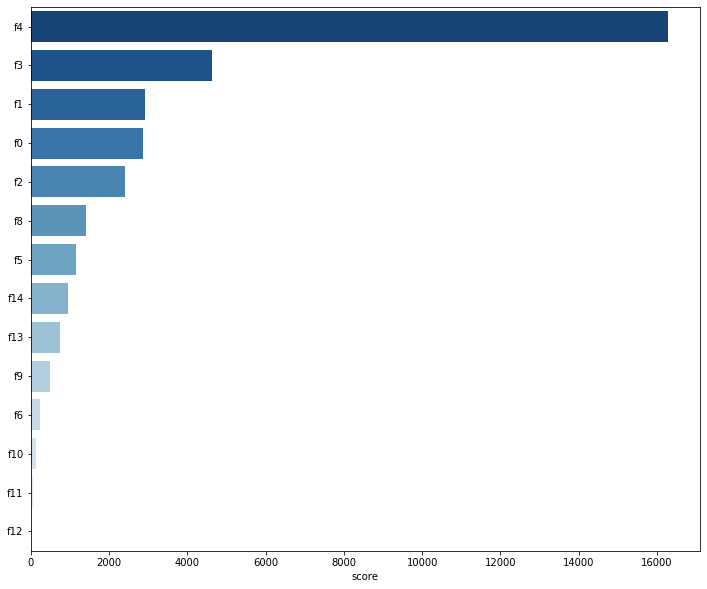

In [23]:
feature_important = xgb_final.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize= (12,10))
sns.barplot(x = data.score , y = data.index, orient = 'h', palette = 'Blues_r')

#### Prediction and Submission

In [24]:
preds_test = submission_pipeline.predict(X_test)

In [25]:
# Save test predictions to file
output = pd.DataFrame({'image_name': X_test_load.image_name,
                       'target': preds_test})
output.to_csv('./cleaned_csvs/csv_only_submission.csv', index=False)